In [1]:
import os
from PIL import Image
import numpy as np
import mxnet as mx
import tqdm
from utils import check_dir
from memory import Memory
from utils import create_input, translate_state
from evaluation_mxnet import evaluate
from mxnet import gluon, nd, autograd
from environments.SimpleEnv import SimpleEnv

/home/seventheli/.local/lib/python3.8/site-packages/gluoncv/__init__.py:40: UserWarning: Both `mxnet==1.9.0` and `torch==1.10.0+cu113` are installed. You might encounter increased GPU memory footprint if both framework are used at the same time.
  warnings.warn(f'Both `mxnet=={mx.__version__}` and `torch=={torch.__version__}` are installed. '


In [2]:
# training cases
order = "model_test"
# batch size
batch_size = 2
# agent view
agent_view = 5
map_size = 20
# action max
action_max = 3
# learning rate
model_save = "./model_save/"
lr = 0.002
num_episode = 1000000
# start play
replay_start = 2000
# update step
update_step = 1000
# gamma in q-loss calculation
gamma = 0.99
# memory pool size
memory_length = 10000
# file to save train log
summary = "./{}_Reward.csv".format(order)
eval_statistics = "./{}_CSV.csv".format(order)
# the number of step it take to linearly anneal the epsilon to it min value
annealing_end = 100000
# min level of stochastically of policy (epsilon)-greedy
epsilon_min = 0.2
# temporary files
temporary_model = "./{}/{}.params".format(model_save, order)
temporary_pool = "./{}/{}.pool".format(model_save, order)

In [3]:
if os.path.exists(summary):
    os.remove(summary)
ctx = mx.gpu()
for i in ["model_save", "data_save"]:
    check_dir(i)

In [4]:
# build models
from model.simple_stack import SimpleStack
online_model = SimpleStack()
offline_model = SimpleStack()
online_model.collect_params().initialize(mx.init.MSRAPrelu(), ctx=ctx)
offline_model.collect_params().initialize(mx.init.MSRAPrelu(), ctx=ctx)
offline_model.collect_params().zero_grad()

In [5]:
# create env
env = SimpleEnv(display=False, agent_view=agent_view, map_size=map_size)
memory_pool = Memory(memory_length)
annealing = 0
total_reward = np.zeros(num_episode)
loss_func = gluon.loss.L2Loss()
trainer = gluon.Trainer(offline_model.collect_params(), 'adam', {'learning_rate': lr, "wd": 0.001})

In [6]:
_print = True
best = 0
_all = 0
_update = 0

In [7]:
_print_structure = 0
for epoch in range(num_episode):
    env.reset_env()
    finish = 0
    cum_clipped_dr = 0
    if _print_structure == 1:
        print("Model Structure: ")
        print(offline_model)
        _print_structure += 1
    eps = np.maximum(1 - sum(env.step_count) / annealing_end, epsilon_min)
    if np.random.random() < eps :
        by = "Random"
    else:
        by = "Model"
        action = np.random.randint(0, action_max)
        _print_structure += 1
    while not finish:
        _all += 1
        if sum(env.step_count) > replay_start:
            annealing += 1
        if by == "Random":
            action = np.random.randint(0, action_max)
            old, new, reward_get, finish = env.step(action)
        else:
            data = create_input([translate_state(env.map.state())])
            data = [nd.array(i, ctx=ctx) for i in data]
            hidden = offline_model.random_state(1, ctx)
            action, hidden = offline_model(data, hidden)
            action = int(nd.argmax(action, axis=1).asnumpy()[0])
        old, new, reward_get, finish = env.step(action)
        memory_pool.add(old, new, action, reward_get, finish)
        if finish and epoch > 50:
            cum_clipped_dr += sum(env.detect_rate[-1]) / 2
            dr_50 = float(np.mean(env.detect_rate[-50:]))
            dr_all = float(np.mean(env.detect_rate))
            ar_50 = float(np.mean(env.rewards[-50:]))
            ar_all = float(np.mean(env.rewards))
            if epoch % 50 == 0 and epoch >= 100:
                text = "DR: %f(50), %f(all), AR: %f(50), %f(all) eps: %f" % (dr_50, dr_all, ar_50, ar_all, eps)
                print(text)
                with open(summary, "a") as f:
                    f.writelines(text + "\n")
            # save model and replace online model each update_step
            if annealing > replay_start and annealing % update_step == 0:
                offline_model.save_parameters(temporary_model)
                online_model.load_parameters(temporary_model, ctx)
                if best < dr_all:
                    best = dr_all
                    offline_model.save_parameters(temporary_model+ ".best")
    #  train every epoch
    if annealing > replay_start:
        _update += 1
        # Sample random mini batch of transitions
        if len(memory_pool.memory) > batch_size:
            bz = batch_size
        else:
            bz = len(memory_pool.memory)
        for_train = memory_pool.next_batch(bz)
        with autograd.record(train_mode=True):
            _state =[nd.array(i, ctx=ctx) for i in for_train["state"]]
            _state_next = [nd.array(i, ctx=ctx) for i in for_train["state_next"]]
            _finish = nd.array(for_train["finish"], ctx=ctx)
            _action = nd.array(for_train["action"], ctx=ctx)
            _reward = nd.array(for_train["reward"], ctx=ctx)
            q_sp = nd.max(online_model(_state_next, offline_model.random_state(batch_size, ctx))[0], axis=1)
            q_sp = q_sp * (nd.ones(bz, ctx=ctx) - _finish)
            q_s_array = offline_model(_state, offline_model.random_state(batch_size, ctx))[0]
            q_s = nd.pick(q_s_array, _action, 1)
            loss = nd.mean(loss_func(q_s, (_reward + gamma * q_sp)))
        loss.backward()
        trainer.step(bz)
    total_reward[int(epoch) - 1] = cum_clipped_dr

Model Structure: 
SimpleStack(
  (map): HybridSequential(
    (0): Conv2D(3 -> 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=16)
    (2): HardSwish(
      (act): HardSigmoid(
        (act): ReLU6(
        
        )
      )
    )
    (3): _ResUnit(
      (conv1): _Unit(
        (conv): Conv2D(1 -> 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
        (bn): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=16)
        (act): Activation(
          (act): Activation(relu)
        )
      )
      (se): _SE(
        (pool): GlobalAvgPool2D(size=(1, 1), stride=(1, 1), padding=(0, 0), ceil_mode=True, global_pool=True, pool_type=avg, layout=NCHW)
        (conv1): Conv2D(16 -> 8, kernel_size=(1, 1), stride=(1, 1))
        (act1): Activation(
          (act): Activation(relu)
        )
        (

DR: 0.039948(50), 0.045933(all), AR: -0.013074(50), -0.012108(all) eps: 0.900000
DR: 0.031738(50), 0.041233(all), AR: -0.011383(50), -0.011868(all) eps: 0.850000
DR: 0.017659(50), 0.035368(all), AR: -0.018269(50), -0.013460(all) eps: 0.800000
DR: 0.037486(50), 0.035790(all), AR: -0.011342(50), -0.013038(all) eps: 0.750000
DR: 0.022145(50), 0.033524(all), AR: -0.028713(50), -0.015642(all) eps: 0.700000
DR: 0.034836(50), 0.033710(all), AR: -0.020204(50), -0.016292(all) eps: 0.650000
DR: 0.036547(50), 0.034064(all), AR: -0.018395(50), -0.016554(all) eps: 0.600000
DR: 0.062064(50), 0.037168(all), AR: -0.019878(50), -0.016923(all) eps: 0.550000
DR: 0.024069(50), 0.035861(all), AR: -0.044922(50), -0.019717(all) eps: 0.500000
DR: 0.036438(50), 0.035913(all), AR: -0.021036(50), -0.019837(all) eps: 0.450000
DR: 0.031353(50), 0.035534(all), AR: -0.031820(50), -0.020834(all) eps: 0.400000
DR: 0.022770(50), 0.034554(all), AR: -0.045349(50), -0.022716(all) eps: 0.350000
DR: 0.061975(50), 0.036510(a

KeyboardInterrupt: 

In [9]:
import seaborn

100%|██████████| 2073/2073 [00:01<00:00, 1128.69it/s]


<AxesSubplot:>

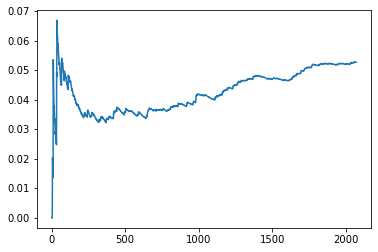

In [10]:
y = []
for i in tqdm.tqdm(range(1, len(env.detect_rate))):
    y.append(np.mean(env.detect_rate[:i]))
seaborn.lineplot(x=range(len(y)), y=y)

100%|██████████| 2073/2073 [00:00<00:00, 9190.56it/s] 


<AxesSubplot:>

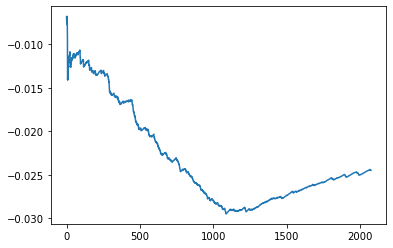

In [11]:
y = []
for i in tqdm.tqdm(range(1, len(env.rewards))):
    y.append(np.mean(env.rewards[:i]))
seaborn.lineplot(x=range(len(y)), y=y)

In [12]:
nd.mean(loss_func(q_s, (_reward + gamma * q_sp)))


[0.00031806]
<NDArray 1 @gpu(0)>